# List of Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from PIL import Image
import random 
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import cv2
import os

# Data visualisation

In [2]:
#get first 5 entries of dataset 
!head -n5 "./global-wheat-detection/train.csv"

image_id,width,height,bbox,source
b6ab77fd7,1024,1024,"[834.0, 222.0, 56.0, 36.0]",usask_1
b6ab77fd7,1024,1024,"[226.0, 548.0, 130.0, 58.0]",usask_1
b6ab77fd7,1024,1024,"[377.0, 504.0, 74.0, 160.0]",usask_1
b6ab77fd7,1024,1024,"[834.0, 95.0, 109.0, 107.0]",usask_1


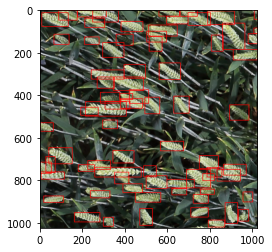

In [2]:
directory = './global-wheat-detection'

train_data = pd.read_csv(directory+'/train.csv')
    
sample = train_data['image_id'].sample().values[0]

img = plt.imread(directory+'/train/{}.jpg'.format(sample))

#draw bounding boxes 
bounding_boxes = pd.concat([train_data[train_data.image_id == sample] ['bbox']])
# bounding_boxes.values
for bounding_box in bounding_boxes: 
    bounding_boxes = [float(x.strip(' []')) for x in bounding_box.split(',')]
    startX = int(bounding_boxes[0])
    startY = int(bounding_boxes[1])
    endX = int(startX + bounding_boxes[2])
    endY = int(startY + bounding_boxes[3])
    cv2.rectangle(img, (startX, startY), (endX, endY), (255, 0, 0), 2)

plt.imshow(img)

# Model 

In [3]:
#i guess find out wht is a better model for object detection?
directory = './global-wheat-detection'

#maximum number of region proposals when doing selective search 
MAX_PROPOSALS = 2000 
MAX_PROPOSALS_INFER = 2000 

#maximum number of positive and negative images to be generated from each image (what is positive and negative image)
MAX_POSITIVE = 30 
MAX_NEGATIVE = 10 

#resize to size 224
INPUT_DIMS = (224, 224)

#model path 
MODEL_PATH = "./wheat_detector.h5"
ENCODER_PATH = "./label_encoder.pickle"

imagePath = os.listdir(directory + '/train')
POSITIVE_PATH = directory + '/processed/train/POSITIVE_PATH'
NEGATIVE_PATH = directory + '/processed/train/NEGATIVE_PATH'
#minimum probability for a positive prediction 
MIN_PROBA = 0.70


In [4]:
def compute_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    return iou

# Generate Region Proposals

In [ ]:
totalPositive = 0 
totalNegative = 0
count = 0
# selective search 

#loop through training images
for i in imagePath: 
    count += 1
    print('processing image {} ({}/3000 images)'.format(i, count))
    img_id = i[:-4]
    bounding_boxes = pd.concat([train_data[train_data.image_id == img_id] ['bbox']])
    gtBoxes = []
    for bounding_box in bounding_boxes: 
        #(x,y,w,h)
        results = bounding_box.strip(' []').split(',')
        results = list(map(float, results))
        #convert to (x,y,xmax,ymax)
        results[2] += results[0]
        results[3] += results[1]
        gtBoxes.append(results)
    
    image = cv2.imread('{}/train/{}'.format(directory, i))
    #run selective search 
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    proposedRects = []
    
    for (x,y,w,h) in rects: 
        proposedRects.append((x,y,x+w,y+h))
        
    #initialise counters used to count number of positive and negative ROIs
    positiveROIs = 0
    negativeROIs = 0
    
    #loop over maximum number of proposals 
    for proposedRect in proposedRects[:MAX_PROPOSALS]:
        (propStartX, propStartY, propEndX, propEndY) = proposedRect
        
        for gtBox in gtBoxes:
            iou = compute_iou(gtBox, proposedRect) 
            (gtStartX, gtStartY, gtEndX, gtEndY) = gtBox
            
            roi = None 
            outputPath = None 
            
            if iou > 0.7 and positiveROIs < MAX_POSITIVE: 
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "/{}.png".format(totalPositive)
                outputPath = POSITIVE_PATH + filename
                
                positiveROIs += 1
                totalPositive += 1
                
            fullOverlap = propStartX >= gtStartX
            fullOverlap = fullOverlap and propStartY >= gtStartY
            fullOverlap = fullOverlap and propEndX <= gtEndX
            fullOverlap = fullOverlap and propEndY <= gtEndY
            
            if not fullOverlap and iou < 0.05 and negativeROIs <= MAX_NEGATIVE:
                roi = image[propStartY:propEndY, propStartX:propEndX]
                filename = "/{}.png".format(totalNegative)
                outputPath = NEGATIVE_PATH + filename
                
                negativeROIs += 1
                totalNegative += 1
            
            if roi is not None and outputPath is not None: 
                roi = cv2.resize(roi, INPUT_DIMS, interpolation=cv2.INTER_CUBIC)
                cv2.imwrite(outputPath, roi)

processing image ccf2bea3e.jpg (1/3000 images)
processing image ccb8097e3.jpg (2/3000 images)
processing image eb9833cca.jpg (3/3000 images)
processing image 8f507b3f7.jpg (4/3000 images)
processing image b3dd471bc.jpg (5/3000 images)
processing image 4fbf0c8b7.jpg (6/3000 images)
processing image d0ca0d7a0.jpg (7/3000 images)
processing image 3843b28ec.jpg (8/3000 images)
processing image 3f5b4ef85.jpg (9/3000 images)
processing image be0fd10b4.jpg (10/3000 images)
processing image c936df99a.jpg (11/3000 images)
processing image 551902572.jpg (12/3000 images)
processing image 3a97dc987.jpg (13/3000 images)
processing image 07f519e11.jpg (14/3000 images)
processing image da5063a1b.jpg (15/3000 images)
processing image 5018112f2.jpg (16/3000 images)
processing image 0e2be222f.jpg (17/3000 images)
processing image 277fff409.jpg (18/3000 images)
processing image 1c90d23fb.jpg (19/3000 images)
processing image feb78a8de.jpg (20/3000 images)
processing image 3c0d9abaa.jpg (21/3000 images)
p

# Train test split

In [5]:
#train test split for RP  (gotta change to train test val split?)
# 60% train, 30% test, 10% val (change dir later)
for dirname, _, filenames in os.walk(directory + '/processed/train_copy'):
    if len(filenames) > 0: 
        train_img, val_img = train_test_split(filenames, test_size=0.2, shuffle=True)
#         test_img, val_img = train_test_split(test_img, test_size=0.25, shuffle=True)

        for img in val_img: 
            os.replace(os.path.join(dirname,img), directory+'/processed/validation/{}/{}'.format(dirname.split('/')[-1], img))
#         for img in val_img: 
#             os.replace(os.path.join(dirname,img), directory+'/processed/validation/{}/{}'.format(dirname.split('/')[-1], img))


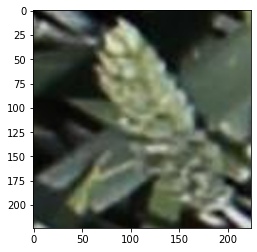

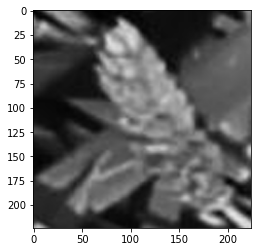

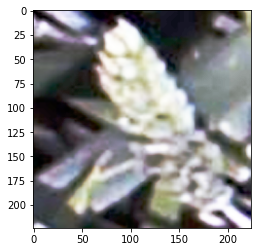

In [58]:
image = cv2.imread(directory + '/processed/train_copy/POSITIVE_PATH/25328.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
y_flip = cv2.flip(image,1)
x_flip = cv2.flip(image, -1)
grey = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
greyscale = cv2.cvtColor(grey, cv2.COLOR_GRAY2RGB)
def hist_equal(img):
#     rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    R, G, B = cv2.split(img)
    output_R = cv2.equalizeHist(R)
    output_G = cv2.equalizeHist(G)
    output_B = cv2.equalizeHist(B)
    equ = cv2.merge((output_R, output_G, output_B))
    return equ

equ = hist_equal(image)
plt.imshow(image)
plt.show()
plt.imshow(greyscale)
plt.show()
plt.imshow(equ)


## DenseNet

In [19]:
#define model parameters 
INIT_LR = 1e-4
EPOCHS = 10
BS = 16

#create datagenerator
datagen = ImageDataGenerator()

train_iterable = datagen.flow_from_directory(directory+'/processed/train_copy', \
                                             class_mode='binary', batch_size=BS,\
                                            target_size=(224, 224))
# test_iterable = datagen.flow_from_directory(directory+'/processed/test', class_mode=None, batch_size=1, target_size=(224, 224))
val_iterable = datagen.flow_from_directory(directory+'/processed/validation', \
                                           class_mode='binary', batch_size=BS, target_size=(224, 224))

# #define model 
# #use rcnn with DenseNet model pretrained with ImageNet
baseModel = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.4)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy","categorical_accuracy"])

checkpoint = ModelCheckpoint("rcnn_denseNet121_v3.h5",\
                            monitor='val_accuracy', verbose=1,\
                            save_best_only=True,\
                            save_weights_only=False,\
                            mode='auto', period=1)
#fit model 
H = model.fit(train_iterable, epochs=EPOCHS, \
              validation_data=val_iterable, \
              batch_size=BS,\
              callbacks=[checkpoint])

#evaluate model
# loss = model.evaluate_generator(test_iterable, steps=24)

Found 57108 images belonging to 2 classes.
Found 14278 images belonging to 2 classes.
[INFO] compiling model...
Epoch 1/10
3570/3570 [==============================] - ETA: 0s - loss: 0.3313 - accuracy: 0.8754 - categorical_accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.91890, saving model to rcnn_denseNet121_v3.h5
3570/3570 [==============================] - 229s 64ms/step - loss: 0.3313 - accuracy: 0.8754 - categorical_accuracy: 1.0000 - val_loss: 0.2214 - val_accuracy: 0.9189 - val_categorical_accuracy: 1.0000
Epoch 2/10
3570/3570 [==============================] - ETA: 0s - loss: 0.2184 - accuracy: 0.9200 - categorical_accuracy: 1.0000
Epoch 00002: val_accuracy improved from 0.91890 to 0.93311, saving model to rcnn_denseNet121_v3.h5
3570/3570 [==============================] - 203s 57ms/step - loss: 0.2184 - accuracy: 0.9200 - categorical_accuracy: 1.0000 - val_loss: 0.1900 - val_accuracy: 0.9331 - val_categorical_accuracy: 1.0000
Epoch 3/10
3569/3570 [=========

### RCNN + inception, train for 10 epochs, image flipping, batch size 32

In [4]:
#define model parameters 
INIT_LR = 1e-4
EPOCHS = 10
BS = 16

#create datagenerator
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2,\
                             height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,\
                             fill_mode="nearest")

train_iterable = datagen.flow_from_directory(directory+'/processed/train_copy', \
                                             class_mode='binary', batch_size=BS,\
                                            target_size=(224, 224))
# test_iterable = datagen.flow_from_directory(directory+'/processed/test', class_mode=None, batch_size=1, target_size=(224, 224))
val_iterable = datagen.flow_from_directory(directory+'/processed/validation', \
                                           class_mode='binary', batch_size=BS, target_size=(224, 224))

# #define model 
# #use rcnn with Inception model pretrained with ImageNet
baseModel = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# baseModel = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation=tf.keras.layers.LeakyReLU(alpha=0.01))(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = True

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy","categorical_accuracy"])

checkpoint = ModelCheckpoint("rcnn_denseNet121_v6.h5",\
                            monitor='val_accuracy', verbose=1,\
                            save_best_only=True,\
                            save_weights_only=False,\
                            mode='auto', period=1)
#fit model 
H = model.fit(train_iterable, epochs=EPOCHS, \
              validation_data=val_iterable, \
              batch_size=BS,\
              callbacks=[checkpoint])

#evaluate model
# loss = model.evaluate_generator(test_iterable, steps=24)

Found 57108 images belonging to 2 classes.
Found 14278 images belonging to 2 classes.
[INFO] compiling model...
Epoch 1/10
3570/3570 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9422 - categorical_accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.96316, saving model to rcnn_denseNet121_v6.h5
3570/3570 [==============================] - 945s 265ms/step - loss: 0.1719 - accuracy: 0.9422 - categorical_accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9632 - val_categorical_accuracy: 1.0000
Epoch 2/10
3570/3570 [==============================] - ETA: 0s - loss: 0.1253 - accuracy: 0.9591 - categorical_accuracy: 1.0000
Epoch 00002: val_accuracy improved from 0.96316 to 0.96519, saving model to rcnn_denseNet121_v6.h5
3570/3570 [==============================] - 871s 244ms/step - loss: 0.1253 - accuracy: 0.9591 - categorical_accuracy: 1.0000 - val_loss: 0.1086 - val_accuracy: 0.9652 - val_categorical_accuracy: 1.0000
Epoch 3/10
2953/3570 [=======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3570/3570 [==============================] - ETA: 0s - loss: 0.0633 - accuracy: 0.9783 - categorical_accuracy: 1.0000
Epoch 00005: val_accuracy improved from 0.97388 to 0.97584, saving model to rcnn_denseNet121_v6.h5
3570/3570 [==============================] - 872s 244ms/step - loss: 0.0633 - accuracy: 0.9783 - categorical_accuracy: 1.0000 - val_loss: 0.0719 - val_accuracy: 0.9758 - val_categorical_accuracy: 1.0000
Epoch 6/10
1065/3570 [=======>......................] - ETA: 8:12 - loss: 0.0560 - accuracy: 0.9809 - categorical_accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



3570/3570 [==============================] - ETA: 0s - loss: 0.0485 - accuracy: 0.9834 - categorical_accuracy: 1.0000
Epoch 00007: val_accuracy improved from 0.97857 to 0.98158, saving model to rcnn_denseNet121_v6.h5
3570/3570 [==============================] - 879s 246ms/step - loss: 0.0485 - accuracy: 0.9834 - categorical_accuracy: 1.0000 - val_loss: 0.0592 - val_accuracy: 0.9816 - val_categorical_accuracy: 1.0000
Epoch 8/10
3570/3570 [==============================] - ETA: 0s - loss: 0.0427 - accuracy: 0.9865 - categorical_accuracy: 1.0000
Epoch 00008: val_accuracy did not improve from 0.98158
3570/3570 [==============================] - 876s 245ms/step - loss: 0.0427 - accuracy: 0.9865 - categorical_accuracy: 1.0000 - val_loss: 0.0647 - val_accuracy: 0.9793 - val_categorical_accuracy: 1.0000
Epoch 9/10
3570/3570 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9865 - categorical_accuracy: 1.0000
Epoch 00009: val_accuracy did not improve from 0.98158
3570/3570

### RCNN + InceptionResNetv2, train for 10 epochs, image flipping, sigmoid activation function

In [31]:
#define model parameters 
INIT_LR = 1e-4
EPOCHS = 10
BS = 32

#create datagenerator
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2,\
                             height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,\
                             fill_mode="nearest")

train_iterable = datagen.flow_from_directory(directory+'/processed/train_copy', \
                                             class_mode='binary', batch_size=BS,\
                                            target_size=(224, 224))
# test_iterable = datagen.flow_from_directory(directory+'/processed/test', class_mode=None, batch_size=1, target_size=(224, 224))
val_iterable = datagen.flow_from_directory(directory+'/processed/validation', \
                                           class_mode='binary', batch_size=BS, target_size=(224, 224))

# #define model 
# #use rcnn with Inception model pretrained with ImageNet
baseModel = tf.keras.applications.InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = True

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy","categorical_accuracy"])

checkpoint = ModelCheckpoint("rcnn_denseNet121_v7.h5",\
                            monitor='val_accuracy', verbose=1,\
                            save_best_only=True,\
                            save_weights_only=False,\
                            mode='auto', period=1)
#fit model 
H = model.fit(train_iterable, epochs=EPOCHS, \
              validation_data=val_iterable, \
              batch_size=BS,\
              callbacks=[checkpoint])

#evaluate model
# loss = model.evaluate_generator(test_iterable, steps=24)

Found 57108 images belonging to 2 classes.
Found 14278 images belonging to 2 classes.
[INFO] compiling model...
Epoch 1/10
1785/1785 [==============================] - ETA: 0s - loss: 0.1373 - accuracy: 0.9549 - categorical_accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.96589, saving model to rcnn_denseNet121_v7.h5
1785/1785 [==============================] - 863s 483ms/step - loss: 0.1373 - accuracy: 0.9549 - categorical_accuracy: 1.0000 - val_loss: 0.1025 - val_accuracy: 0.9659 - val_categorical_accuracy: 1.0000
Epoch 2/10
1785/1785 [==============================] - ETA: 0s - loss: 0.0728 - accuracy: 0.9748 - categorical_accuracy: 1.0000
Epoch 00002: val_accuracy improved from 0.96589 to 0.97142, saving model to rcnn_denseNet121_v7.h5
1785/1785 [==============================] - 855s 479ms/step - loss: 0.0728 - accuracy: 0.9748 - categorical_accuracy: 1.0000 - val_loss: 0.0778 - val_accuracy: 0.9714 - val_categorical_accuracy: 1.0000
Epoch 3/10
1785/1785 [=======

### RCNN + densenet121, train for 10 epochs, image flipping bla bla 

In [27]:
#define model parameters 
INIT_LR = 1e-4
EPOCHS = 10
BS = 16

#create datagenerator
datagen = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2,\
                             height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,\
                             fill_mode="nearest")

train_iterable = datagen.flow_from_directory(directory+'/processed/train_copy', \
                                             class_mode='binary', batch_size=BS,\
                                            target_size=(224, 224))
# test_iterable = datagen.flow_from_directory(directory+'/processed/test', class_mode=None, batch_size=1, target_size=(224, 224))
val_iterable = datagen.flow_from_directory(directory+'/processed/validation', \
                                           class_mode='binary', batch_size=BS, target_size=(224, 224))

# #define model 
# #use rcnn with DenseNet model pretrained with ImageNet
baseModel = tf.keras.applications.DenseNet121(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy","categorical_accuracy"])

checkpoint = ModelCheckpoint("rcnn_denseNet121_v5.h5",\
                            monitor='val_accuracy', verbose=1,\
                            save_best_only=True,\
                            save_weights_only=False,\
                            mode='auto', period=1)
#fit model 
H = model.fit(train_iterable, epochs=EPOCHS, \
              validation_data=val_iterable, \
              batch_size=BS,\
              callbacks=[checkpoint])

#evaluate model
# loss = model.evaluate_generator(test_iterable, steps=24)


Found 57108 images belonging to 2 classes.
Found 14278 images belonging to 2 classes.
[INFO] compiling model...
Epoch 1/10
3570/3570 [==============================] - ETA: 0s - loss: 0.3874 - accuracy: 0.8499 - categorical_accuracy: 1.0000
Epoch 00001: val_accuracy improved from -inf to 0.89284, saving model to rcnn_denseNet121_v5.h5
3570/3570 [==============================] - 852s 239ms/step - loss: 0.3874 - accuracy: 0.8499 - categorical_accuracy: 1.0000 - val_loss: 0.2716 - val_accuracy: 0.8928 - val_categorical_accuracy: 1.0000
Epoch 2/10
3570/3570 [==============================] - ETA: 0s - loss: 0.2750 - accuracy: 0.8927 - categorical_accuracy: 1.0000
Epoch 00002: val_accuracy improved from 0.89284 to 0.90671, saving model to rcnn_denseNet121_v5.h5
3570/3570 [==============================] - 850s 238ms/step - loss: 0.2750 - accuracy: 0.8927 - categorical_accuracy: 1.0000 - val_loss: 0.2415 - val_accuracy: 0.9067 - val_categorical_accuracy: 1.0000
Epoch 3/10
3570/3570 [=======

### Results of v3

processing image 796707dd7.jpg (1/10 images)
99.35%
98.50%
97.79%
93.76%
90.70%
87.72%
84.99%
73.06%
61.83%
52.36%
49.58%
27.16%
14.92%
14.56%
9.50%


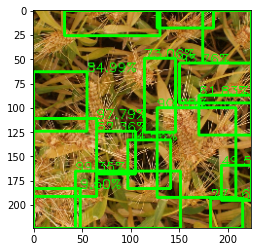

processing image 51f1be19e.jpg (2/10 images)
99.97%
99.97%
99.95%
99.88%
98.16%
97.15%
95.63%
95.49%
93.63%
86.30%
84.19%
15.84%


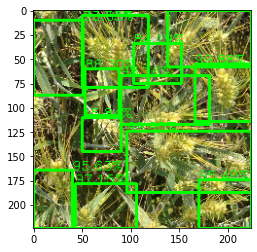

processing image 51b3e36ab.jpg (3/10 images)
99.99%
99.90%
99.75%
99.52%
99.02%
97.28%
96.66%
94.57%
94.34%
85.92%
80.04%
55.18%
43.58%
37.66%
35.74%
26.48%
3.90%


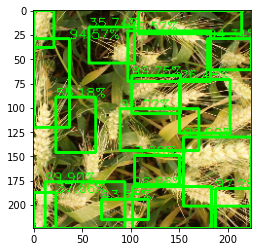

processing image aac893a91.jpg (4/10 images)
99.74%
99.71%
99.02%
98.79%
95.43%
79.35%
73.20%
70.60%
69.52%
56.17%
30.18%
14.82%
13.93%
11.51%
6.18%
3.88%


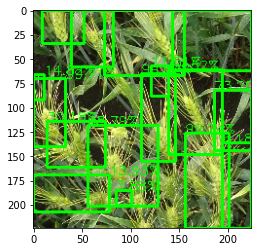

processing image cc3532ff6.jpg (5/10 images)
99.94%
99.93%
98.31%
94.77%
83.31%
68.36%
65.29%
60.65%
57.58%
49.16%
43.73%
38.20%
14.39%
5.38%
4.20%


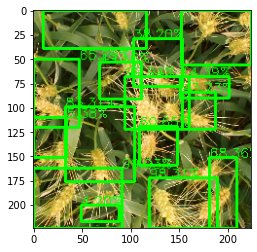

processing image 348a992bb.jpg (6/10 images)
98.63%
98.03%
97.14%
92.82%
90.83%
82.61%
81.71%
77.61%
57.08%
56.13%
48.57%
28.83%
20.44%
19.36%
4.29%
3.28%
2.75%


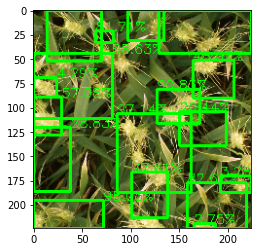

processing image 2fd875eaa.jpg (7/10 images)
98.68%
98.17%
97.00%
91.69%
88.90%
87.08%
82.51%
80.90%
78.57%
75.45%
72.27%
62.39%
46.40%
43.59%
28.55%
25.13%
18.93%
15.98%
13.00%
8.27%
7.04%
2.62%
2.56%


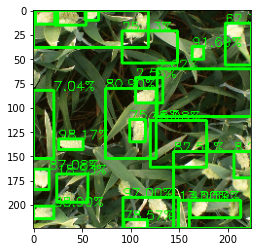

processing image f5a1f0358.jpg (8/10 images)
99.97%
99.35%
99.24%
99.09%
98.18%
90.50%
80.71%
79.87%
63.19%
46.54%
42.79%
40.58%
34.39%
3.62%


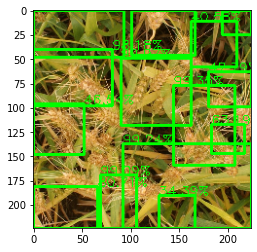

processing image cb8d261a3.jpg (9/10 images)
97.96%
96.56%
96.05%
90.57%
86.40%
78.44%
69.29%
67.25%
55.77%
41.88%
39.96%
20.37%
16.01%
10.69%
8.84%
6.79%
2.91%


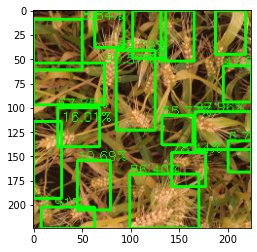

processing image 53f253011.jpg (10/10 images)
99.80%
99.58%
99.45%
98.00%
96.46%
96.20%
88.84%
87.24%
85.30%
85.01%
84.00%
79.29%
74.51%
44.91%
40.17%
33.75%
4.42%
3.94%
3.16%
2.64%
2.47%


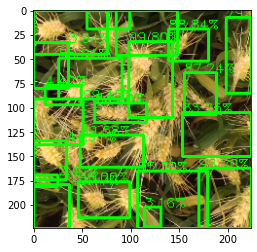

In [8]:
#selective search on the test set 
#Pass the test image to selective search 
#and then pass the first 2000 proposed regions 
# from the trained model and predict the class of those regions.

totalPositive = 0 
totalNegative = 0
count = 0

model = load_model("rcnn_denseNet121_v3.h5")
# selective search 

#loop through training images
for i in os.listdir(directory + '/test'): 
    count += 1
    print('processing image {} ({}/{} images)'.format(i, count,len(list(os.listdir(directory + '/test')))))
    img_id = i[:-4]
    
    image = cv2.imread('{}/test/{}'.format(directory, i))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    #run selective search 
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imout = image.copy()
    
    #[(confidence), (result)]
    confidence_list = []
    for counter, result in enumerate(rects):
        if counter < 2000: 
            x,y,w,h = result 
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out = model.predict(img)
            confidence_list.append((x,y,out[0][0], w,h))
#     confidence_list.sort(key=lambda x:x[0])

    #non-maximum suppression 
    nms_list = nms(confidence_list)
    for i in nms_list: 
        x,y, confidence, w, h = i
        if confidence > 0.02: 
            cv2.rectangle(imout, (x,y), (x+w, y+h), (0,255,0), 2)
            text = "{:.2f}%".format(confidence*100)
            print(text)
            cv2.putText(imout, text, (x if x > 1 else x+w,y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    plt.imshow(imout)
    plt.show() 



### results of rcnndenseNet121_v4

processing image 796707dd7.jpg (1/10 images)
[[0.48787874, array([83, 73, 22, 13], dtype=int32)], [0.4883248, array([ 96, 151,  18,  28], dtype=int32)], [0.48977324, array([ 97, 163,  14,  20], dtype=int32)], [0.49434978, array([134,  22,  14,  13], dtype=int32)], [0.4944968, array([ 73, 116,  14,  15], dtype=int32)], [0.494853, array([  6, 106,  17,  16], dtype=int32)], [0.49616882, array([194,  86,  14,  20], dtype=int32)], [0.4992674, array([182,  91,  15,  22], dtype=int32)], [0.4999988, array([ 57, 143,  31,  39], dtype=int32)], [0.4999988, array([194, 198,  30,  26], dtype=int32)]]
[[0.50000036, array([117,  92,  93, 112], dtype=int32)], [0.50000036, array([127,  95,  97, 105], dtype=int32)], [0.50000036, array([117,  65, 107, 139], dtype=int32)], [0.50000036, array([117,  86, 107, 118], dtype=int32)], [0.5000004, array([127, 100,  97,  94], dtype=int32)], [0.5000004, array([127, 100,  97, 100], dtype=int32)], [0.50000054, array([117,  92, 107, 112], dtype=int32)], [0.5000007, ar

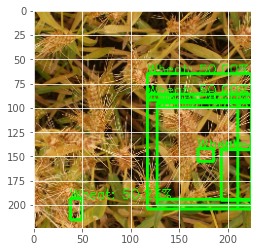

processing image 51f1be19e.jpg (2/10 images)
[[0.46092448, array([ 15, 138,  14,  16], dtype=int32)], [0.4776821, array([99, 81, 16, 25], dtype=int32)], [0.47809154, array([116,  85,  10,  20], dtype=int32)], [0.47953552, array([133,  76,  12,  22], dtype=int32)], [0.4823114, array([165, 185,  14,  16], dtype=int32)], [0.48465618, array([122, 178,  14,  24], dtype=int32)], [0.48509404, array([  2, 142,  10,  20], dtype=int32)], [0.4864074, array([ 58, 110,  16,  28], dtype=int32)], [0.4867984, array([40, 33, 18, 13], dtype=int32)], [0.4892058, array([  0, 144,  12,  32], dtype=int32)]]
[[0.49999946, array([93,  0, 43, 53], dtype=int32)], [0.4999995, array([149,  74,  75,  62], dtype=int32)], [0.49999955, array([  0,  37,  29, 117], dtype=int32)], [0.49999964, array([ 90,   0, 134, 171], dtype=int32)], [0.50060576, array([164,  95,  18,  11], dtype=int32)], [0.50063586, array([165,  93,  17,  11], dtype=int32)], [0.5006621, array([ 0,  0,  8, 19], dtype=int32)], [0.5006754, array([159, 

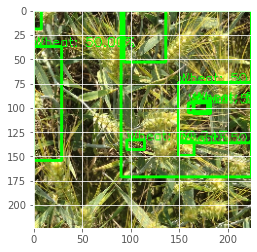

processing image 51b3e36ab.jpg (3/10 images)
[[0.47496006, array([159,  44,  16,  12], dtype=int32)], [0.4768872, array([168,  62,  19,  14], dtype=int32)], [0.48277155, array([125,  63,  33,  10], dtype=int32)], [0.48466134, array([211,  32,  13,  16], dtype=int32)], [0.4848276, array([174, 198,  20,  11], dtype=int32)], [0.4852533, array([108,   0,  52,  16], dtype=int32)], [0.4873852, array([110,   0,  50,  16], dtype=int32)], [0.49092084, array([116,  14,  14,  12], dtype=int32)], [0.49417076, array([  2, 160,  21,  28], dtype=int32)], [0.49540105, array([164,  59,  16,  13], dtype=int32)]]
[[0.49999943, array([82,  4, 21, 32], dtype=int32)], [0.49999943, array([ 18, 125, 154,  99], dtype=int32)], [0.49999943, array([ 87,  70, 137,  77], dtype=int32)], [0.49999943, array([ 90, 149, 134,  75], dtype=int32)], [0.4999995, array([ 92,  54, 117,  61], dtype=int32)], [0.4999995, array([178, 176,  30,  12], dtype=int32)], [0.4999995, array([ 23,   0, 201, 224], dtype=int32)], [0.49999955,

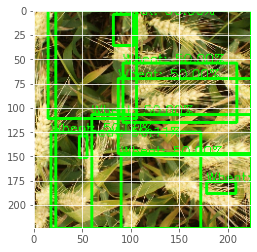

processing image aac893a91.jpg (4/10 images)
[[0.4680418, array([113, 172,  13,  28], dtype=int32)], [0.47006732, array([128, 193,  17,  13], dtype=int32)], [0.4714727, array([24, 96, 18, 26], dtype=int32)], [0.47241768, array([ 93, 203,  16,  13], dtype=int32)], [0.47591805, array([129, 193,  14,  13], dtype=int32)], [0.47701165, array([126,  56,  12,  22], dtype=int32)], [0.47744378, array([129, 192,  15,  14], dtype=int32)], [0.4816766, array([  0, 191,  20,  11], dtype=int32)], [0.48223066, array([ 57, 115,  14,  16], dtype=int32)], [0.48604918, array([ 93, 203,  15,  13], dtype=int32)]]
[[0.4999993, array([196, 100,  28,  76], dtype=int32)], [0.49999937, array([111,  75,  18,  42], dtype=int32)], [0.49999937, array([113,  47, 111, 177], dtype=int32)], [0.4999996, array([ 58, 107,  28,  24], dtype=int32)], [0.4999996, array([196, 135,  28,  89], dtype=int32)], [0.50000006, array([15, 52, 14, 52], dtype=int32)], [0.5000002, array([15, 52, 14, 55], dtype=int32)], [0.50000066, array([

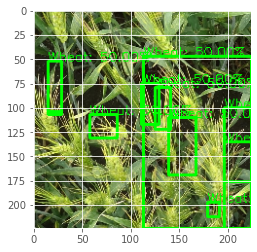

processing image cc3532ff6.jpg (5/10 images)
[[0.47420385, array([  0, 143,  11,  14], dtype=int32)], [0.48808926, array([  0, 143,  10,  14], dtype=int32)], [0.49250206, array([118,  75,  14,  23], dtype=int32)], [0.49570516, array([ 11, 213,  14,  11], dtype=int32)], [0.49612114, array([93, 68, 16, 19], dtype=int32)], [0.49675348, array([128, 103,  33,  16], dtype=int32)], [0.49709657, array([69, 51, 23,  9], dtype=int32)], [0.49738455, array([150, 197,  27,  12], dtype=int32)], [0.4987522, array([118,  76,  14,  22], dtype=int32)], [0.49950704, array([191, 152,  22,  32], dtype=int32)]]
[[0.4999998, array([124, 121,  17,  20], dtype=int32)], [0.50000095, array([ 42, 116,  22,  35], dtype=int32)], [0.50002766, array([ 28, 203,  13,  21], dtype=int32)], [0.5001362, array([89, 64, 14, 14], dtype=int32)], [0.50021887, array([120, 208,  17,  16], dtype=int32)], [0.5009007, array([154,  14,  17,  10], dtype=int32)], [0.50127953, array([199, 214,  15,  10], dtype=int32)], [0.50165224, arra

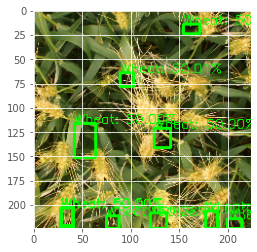

processing image 348a992bb.jpg (6/10 images)
[[0.4761071, array([184,  17,  18,  16], dtype=int32)], [0.47660992, array([ 0, 58, 16, 15], dtype=int32)], [0.48145035, array([153,  75,  19,  12], dtype=int32)], [0.48246384, array([64, 21, 18, 12], dtype=int32)], [0.49447328, array([212, 149,  12,  28], dtype=int32)], [0.4946845, array([188, 206,  13,  18], dtype=int32)], [0.49468905, array([215, 149,   9,  14], dtype=int32)], [0.49530056, array([211, 121,  13,  28], dtype=int32)], [0.49549752, array([ 0, 58, 15, 15], dtype=int32)], [0.4971021, array([207, 172,  17,  16], dtype=int32)]]
[[0.49999955, array([129,   0,  95,  98], dtype=int32)], [0.49999955, array([  2, 145,  88,  79], dtype=int32)], [0.4999996, array([  0, 119, 167, 105], dtype=int32)], [0.49999964, array([  0, 113,  99, 111], dtype=int32)], [0.49999967, array([128,   0,  96,  98], dtype=int32)], [0.4999997, array([  0, 113, 115, 111], dtype=int32)], [0.49999973, array([  0,  98, 115, 126], dtype=int32)], [0.49999973, array

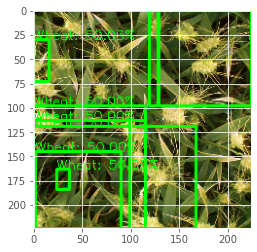

processing image 2fd875eaa.jpg (7/10 images)


KeyboardInterrupt: 

In [134]:
totalPositive = 0 
totalNegative = 0
count = 0

#get the top 10 confidence boxes
# model = load_model("rcnn_denseNet121_v3.h5")
# selective search 

#loop through training images
for i in os.listdir(directory + '/test'): 
    count += 1
    print('processing image {} ({}/{} images)'.format(i, count,len(list(os.listdir(directory + '/test')))))
    img_id = i[:-4]
    
    image = cv2.imread('{}/test/{}'.format(directory, i))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    #run selective search 
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imout = image.copy()
    
    #[(confidence), (result)]
    confidence_list = []
    for counter, result in enumerate(rects):
        if counter < 2000: 
            x,y,w,h = result 
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out = model.predict(img)
            confidence_list.append([out[0][1], result])
    confidence_list.sort(key=lambda x:x[0])
    print(confidence_list[:10])
    print(confidence_list[-10:])
    for i in confidence_list[-10:]: 
        confidence, result = i
        x,y,w,h = result
#         if confidence > 0.60: 
        cv2.rectangle(imout, (x,y), (x+w, y+h), (0,255,0), 2)
        text = "Wheat: {:.2f}%".format(confidence*100)
        print(text)
        cv2.putText(imout, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    plt.imshow(imout)
    plt.show() 

### result of rcnn densenet v5

processing image 796707dd7.jpg (1/10 images)
[[0.40710145, array([153,   0,  33,  14], dtype=int32)], [0.46939257, array([ 96, 151,  18,  28], dtype=int32)], [0.47388354, array([156,   0,  29,  14], dtype=int32)], [0.4778628, array([ 41,   0, 183, 224], dtype=int32)], [0.47825184, array([213, 193,  11,  31], dtype=int32)], [0.4783019, array([127,   0,  58,  18], dtype=int32)], [0.47958696, array([178,  93,  14,  14], dtype=int32)], [0.48088315, array([194, 198,  30,  26], dtype=int32)], [0.4818935, array([127,   0,  47,  15], dtype=int32)], [0.48755702, array([  6, 106,  17,  16], dtype=int32)]]
[[0.5108076, array([ 32,   0, 192,  54], dtype=int32)], [0.5112786, array([ 73, 116,  14,  15], dtype=int32)], [0.51140374, array([83, 73, 22, 13], dtype=int32)], [0.51233417, array([ 32,   0, 153,  26], dtype=int32)], [0.51295733, array([ 38, 193,  12,  22], dtype=int32)], [0.515547, array([ 0,  0, 67, 56], dtype=int32)], [0.5157067, array([194,  86,  14,  20], dtype=int32)], [0.5181758, array

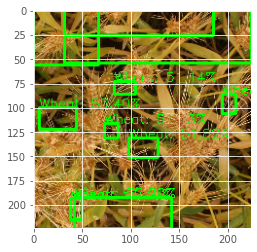

processing image 51f1be19e.jpg (2/10 images)
[[0.37190196, array([ 90,   0, 134, 224], dtype=int32)], [0.4205675, array([ 87,   0, 137, 224], dtype=int32)], [0.421171, array([ 35, 140,  56,  63], dtype=int32)], [0.43849537, array([ 90,   0, 134, 171], dtype=int32)], [0.4391905, array([  0,   0, 224, 224], dtype=int32)], [0.4397104, array([  0,   0, 139, 224], dtype=int32)], [0.44992235, array([118,  82, 106, 142], dtype=int32)], [0.45150417, array([ 87,  74, 137, 150], dtype=int32)], [0.4520927, array([  0,   0, 181, 224], dtype=int32)], [0.4537045, array([132, 111,  92,  95], dtype=int32)]]
[[0.58465946, array([ 94, 118,  30,  25], dtype=int32)], [0.5855888, array([  0, 122,  28,  57], dtype=int32)], [0.5859083, array([  4, 121,  25,  33], dtype=int32)], [0.61531067, array([97, 31, 14, 15], dtype=int32)], [0.62453324, array([ 0, 84, 26, 52], dtype=int32)], [0.6389949, array([  0, 106,  29,  48], dtype=int32)], [0.6435675, array([ 0, 84, 29, 60], dtype=int32)], [0.6495664, array([120, 

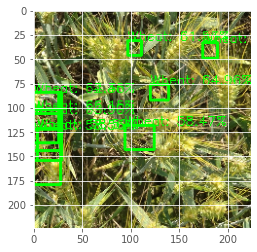

processing image 51b3e36ab.jpg (3/10 images)
[[0.34619296, array([48, 59, 27, 23], dtype=int32)], [0.34632614, array([46, 58, 30, 24], dtype=int32)], [0.43207213, array([167, 160,  41,  28], dtype=int32)], [0.43986893, array([126,  57,  29,  17], dtype=int32)], [0.44829896, array([171,  84,  31,   7], dtype=int32)], [0.4725207, array([168,  62,  19,  14], dtype=int32)], [0.47361472, array([125,  74,  23,  12], dtype=int32)], [0.47618407, array([126,  57,  25,  15], dtype=int32)], [0.4782425, array([13, 85, 27, 38], dtype=int32)], [0.48291495, array([ 20, 176,  21,  23], dtype=int32)]]
[[0.544773, array([  0,   0,  31, 224], dtype=int32)], [0.5552144, array([108,   0,  52,  16], dtype=int32)], [0.55957144, array([159,  61,  28,  21], dtype=int32)], [0.56886554, array([15, 88, 53, 58], dtype=int32)], [0.56898534, array([112,  54,  66,  31], dtype=int32)], [0.62289345, array([168, 164,  33,  16], dtype=int32)], [0.6353447, array([125,  63,  33,  10], dtype=int32)], [0.6359942, array([  2,

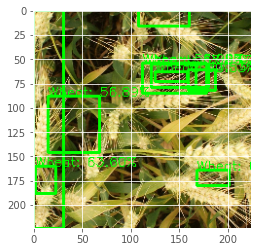

processing image aac893a91.jpg (4/10 images)
[[0.27890038, array([ 93, 203,  16,  13], dtype=int32)], [0.34044114, array([ 7, 68,  8, 34], dtype=int32)], [0.3720053, array([ 57, 115,  14,  16], dtype=int32)], [0.42161217, array([129, 193,  14,  13], dtype=int32)], [0.42494452, array([ 93, 203,  15,  13], dtype=int32)], [0.44503936, array([195, 129,  16,  20], dtype=int32)], [0.44649324, array([148, 209,  16,  15], dtype=int32)], [0.45683753, array([ 85, 185,  16,  15], dtype=int32)], [0.45759565, array([83, 38, 14, 33], dtype=int32)], [0.45801738, array([ 42, 170,  36,  18], dtype=int32)]]
[[0.58221656, array([179, 122,  18,  60], dtype=int32)], [0.58373946, array([196, 135,  17,  41], dtype=int32)], [0.58646256, array([  0, 131,  29,  29], dtype=int32)], [0.5904104, array([  0, 129,  32,  31], dtype=int32)], [0.59625435, array([23, 60, 14, 60], dtype=int32)], [0.6034076, array([47, 82, 59, 75], dtype=int32)], [0.6061305, array([24, 76, 95, 79], dtype=int32)], [0.6427159, array([48, 76

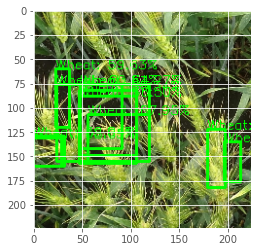

processing image cc3532ff6.jpg (5/10 images)
[[0.20140958, array([89, 64, 14, 14], dtype=int32)], [0.4205824, array([180, 116,  44,  14], dtype=int32)], [0.43545604, array([70, 72, 41, 19], dtype=int32)], [0.4381809, array([80,  0, 22, 24], dtype=int32)], [0.44093564, array([199, 211,  14,  13], dtype=int32)], [0.44423968, array([  0, 142,  88,  82], dtype=int32)], [0.44684118, array([79, 68, 29, 19], dtype=int32)], [0.45123392, array([  0, 146,  95,  78], dtype=int32)], [0.46143794, array([93, 68, 16, 19], dtype=int32)], [0.46221876, array([ 26, 142,  69,  82], dtype=int32)]]
[[0.5814403, array([103,  29,  56,  57], dtype=int32)], [0.58173144, array([144,  59,  26,  15], dtype=int32)], [0.5888287, array([109,  44,  50,  42], dtype=int32)], [0.59290636, array([ 29, 204,  46,  20], dtype=int32)], [0.61148614, array([193,  22,  31,  14], dtype=int32)], [0.616946, array([186,  11,  38,  12], dtype=int32)], [0.61970013, array([186,   0,  27,  14], dtype=int32)], [0.62608504, array([192,  1

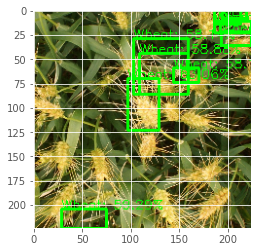

processing image 348a992bb.jpg (6/10 images)
[[0.41927063, array([197,  95,  12,  22], dtype=int32)], [0.45894355, array([198,  95,  16,  21], dtype=int32)], [0.4608031, array([64, 21, 18, 12], dtype=int32)], [0.46468088, array([  0,  27,  37, 123], dtype=int32)], [0.47903433, array([  0,  26,  38, 108], dtype=int32)], [0.485796, array([  0,   0,  44, 128], dtype=int32)], [0.48595873, array([ 58, 169,  76,  55], dtype=int32)], [0.48770294, array([  0,  26,  42, 121], dtype=int32)], [0.48881367, array([188,  52,  11,  16], dtype=int32)], [0.48991877, array([184,  66,  22,  17], dtype=int32)]]
[[0.5312503, array([169,  40,  18,  14], dtype=int32)], [0.533554, array([  0,   0, 134,  66], dtype=int32)], [0.537303, array([148, 104,  35,  28], dtype=int32)], [0.5422535, array([153,  51,  53,  44], dtype=int32)], [0.55048096, array([201, 132,  23,  46], dtype=int32)], [0.56110996, array([153,  45,  71,  53], dtype=int32)], [0.5627649, array([200, 121,  24,  31], dtype=int32)], [0.58539397, ar

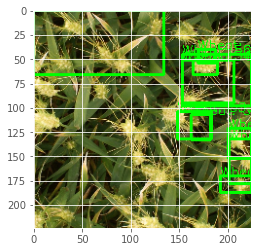

processing image 2fd875eaa.jpg (7/10 images)
[[0.460147, array([11, 98, 10, 26], dtype=int32)], [0.47201535, array([ 0, 30, 20, 11], dtype=int32)], [0.4831388, array([177, 115,  21,   9], dtype=int32)], [0.4869877, array([200, 215,  19,   9], dtype=int32)], [0.48799154, array([  0, 168, 150,  56], dtype=int32)], [0.49090692, array([153,  89,  20,  13], dtype=int32)], [0.49134776, array([178, 113,  23,  11], dtype=int32)], [0.49182627, array([ 72, 174,  21,  21], dtype=int32)], [0.49211368, array([ 38, 201,  15,  11], dtype=int32)], [0.49290553, array([160, 133,  30,  15], dtype=int32)]]
[[0.5027079, array([48, 71, 10, 19], dtype=int32)], [0.5030413, array([ 0, 16, 12, 14], dtype=int32)], [0.50322574, array([90, 64, 43, 45], dtype=int32)], [0.5055722, array([  0, 163,  16,  21], dtype=int32)], [0.5082912, array([ 2,  0, 52, 15], dtype=int32)], [0.50829667, array([  0, 163,  16,  28], dtype=int32)], [0.5155404, array([136, 198,  14,  18], dtype=int32)], [0.5240065, array([ 0, 38, 30, 65]

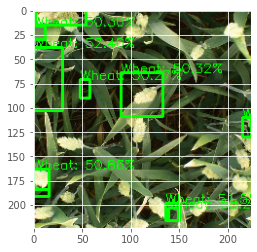

processing image f5a1f0358.jpg (8/10 images)
[[0.44418922, array([  6, 207,  12,  13], dtype=int32)], [0.48227715, array([202,  18,  22,  48], dtype=int32)], [0.48376822, array([198, 181,  26,  43], dtype=int32)], [0.48796877, array([  0,   0, 112, 102], dtype=int32)], [0.4893905, array([52,  0, 40, 32], dtype=int32)], [0.48960772, array([  2, 101,  21,   7], dtype=int32)], [0.48965272, array([ 58, 111,  16,  20], dtype=int32)], [0.4901541, array([  5, 207,  11,  13], dtype=int32)], [0.49122187, array([  6, 203,  17,  17], dtype=int32)], [0.49337772, array([191, 203,  27,  19], dtype=int32)]]
[[0.5275147, array([129, 177,  95,  47], dtype=int32)], [0.527709, array([22, 97, 16, 10], dtype=int32)], [0.52941555, array([158,  76,  39,  14], dtype=int32)], [0.53043926, array([22, 97, 16,  9], dtype=int32)], [0.53074104, array([110, 177, 114,  47], dtype=int32)], [0.53145915, array([101, 178, 123,  46], dtype=int32)], [0.5385449, array([107, 190, 103,  34], dtype=int32)], [0.5616738, array([

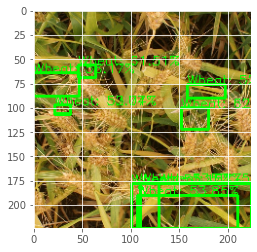

processing image cb8d261a3.jpg (9/10 images)
[[0.47903284, array([  0, 114,  29,  79], dtype=int32)], [0.48029107, array([  0, 114,  29, 110], dtype=int32)], [0.48153865, array([ 0, 27, 30, 34], dtype=int32)], [0.48588583, array([  0, 178,  11,  46], dtype=int32)], [0.48646235, array([ 0,  9, 62, 88], dtype=int32)], [0.4882877, array([102,   0,  83, 124], dtype=int32)], [0.4902333, array([ 45, 154,  34,  51], dtype=int32)], [0.49071893, array([ 0,  9, 50, 52], dtype=int32)], [0.49144292, array([  0, 139,  29,  85], dtype=int32)], [0.49151713, array([102,  88,  18,  34], dtype=int32)]]
[[0.51506656, array([102,   0,  34,  46], dtype=int32)], [0.51529956, array([87, 22, 21, 32], dtype=int32)], [0.518032, array([114,   0, 110, 124], dtype=int32)], [0.5198639, array([131,   0,  93, 117], dtype=int32)], [0.5203712, array([66,  0, 70, 46], dtype=int32)], [0.5245252, array([131,   0,  93, 116], dtype=int32)], [0.5284526, array([  8, 202, 100,  22], dtype=int32)], [0.5285269, array([55,  0, 93

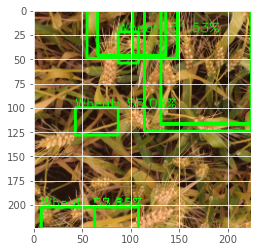

processing image 53f253011.jpg (10/10 images)
[[0.46260965, array([  0, 138, 177,  86], dtype=int32)], [0.4680198, array([107, 157, 103,  67], dtype=int32)], [0.47082815, array([ 82, 136,  54,  54], dtype=int32)], [0.47487748, array([ 29, 114, 105,  78], dtype=int32)], [0.47891605, array([ 37, 149, 173,  75], dtype=int32)], [0.48025507, array([ 48, 128,  86,  64], dtype=int32)], [0.4812647, array([ 20, 108,  93,  84], dtype=int32)], [0.48139054, array([155,  64,  33,  43], dtype=int32)], [0.48221657, array([  0, 149, 210,  75], dtype=int32)], [0.48262045, array([111, 141, 113,  83], dtype=int32)]]
[[0.55380976, array([186, 209,  22,  15], dtype=int32)], [0.56152815, array([152, 154,  25,  15], dtype=int32)], [0.5669402, array([ 0,  0, 27, 14], dtype=int32)], [0.5766204, array([ 0,  0, 27, 11], dtype=int32)], [0.5818321, array([  0, 121,  12,  15], dtype=int32)], [0.5830324, array([ 46, 193,  33,  20], dtype=int32)], [0.5877939, array([178, 208,  28,  16], dtype=int32)], [0.6011726, arr

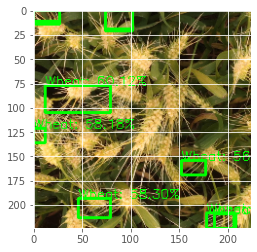

In [17]:
totalPositive = 0 
totalNegative = 0
count = 0

#get the top 10 confidence boxes
model = load_model("rcnn_denseNet121_v5.h5")
# selective search 

#loop through training images
for i in os.listdir(directory + '/test'): 
    count += 1
    print('processing image {} ({}/{} images)'.format(i, count,len(list(os.listdir(directory + '/test')))))
    img_id = i[:-4]
    
    image = cv2.imread('{}/test/{}'.format(directory, i))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    #run selective search 
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imout = image.copy()
    
    #[(confidence), (result)]
    confidence_list = []
    for counter, result in enumerate(rects):
        if counter < 2000: 
            x,y,w,h = result 
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out = model.predict(img)
            confidence_list.append([out[0][0], result])
    confidence_list.sort(key=lambda x:x[0])
    print(confidence_list[:10])
    print(confidence_list[-10:])
    for i in confidence_list[-10:]: 
        confidence, result = i
        x,y,w,h = result
#         if confidence > 0.60: 
        cv2.rectangle(imout, (x,y), (x+w, y+h), (0,255,0), 2)
        text = "Wheat: {:.2f}%".format(confidence*100)
        print(text)
        cv2.putText(imout, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    plt.imshow(imout)
    plt.show() 

### Non maximum suppression

In [5]:
def overlapping_area(detection_1, detection_2):
    
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

def nms(detections, threshold=.1):
   
    detections = sorted(detections, key=lambda detections: detections[2],
            reverse=True)
    
    new_detections=[]
    
    new_detections.append(detections[0])
    
    del detections[0]
    
    for index, detection in enumerate(detections):
        for new_detection in new_detections:
            if overlapping_area(detection, new_detection) > threshold:
                del detections[index]
                break
        else:
            new_detections.append(detection)
            del detections[index]
    return new_detections




### results of v6

processing image 796707dd7.jpg (1/10 images)
Wheat: 52.77%
Wheat: 42.26%
Wheat: 18.33%
Wheat: 16.89%
Wheat: 2.80%
Wheat: 2.39%


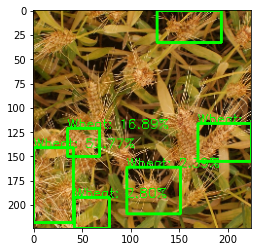

processing image 51f1be19e.jpg (2/10 images)
Wheat: 100.00%
Wheat: 100.00%
Wheat: 91.32%
Wheat: 66.45%
Wheat: 20.35%
Wheat: 5.38%
Wheat: 5.02%
Wheat: 3.94%
Wheat: 3.68%
Wheat: 2.83%
Wheat: 2.16%
Wheat: 1.85%
Wheat: 1.79%
Wheat: 1.45%


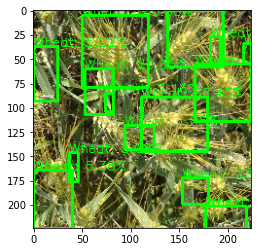

processing image 51b3e36ab.jpg (3/10 images)
Wheat: 100.00%
Wheat: 99.99%
Wheat: 99.93%
Wheat: 99.63%
Wheat: 97.04%
Wheat: 94.64%
Wheat: 91.44%
Wheat: 75.86%
Wheat: 58.80%
Wheat: 39.26%
Wheat: 5.04%


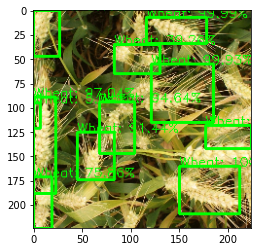

processing image aac893a91.jpg (4/10 images)
Wheat: 99.52%
Wheat: 99.10%
Wheat: 95.23%
Wheat: 89.80%
Wheat: 66.46%
Wheat: 45.82%
Wheat: 11.62%
Wheat: 8.39%
Wheat: 8.20%
Wheat: 6.52%
Wheat: 5.43%
Wheat: 2.70%
Wheat: 1.73%
Wheat: 1.57%
Wheat: 1.10%


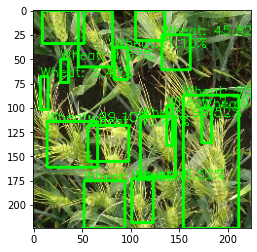

processing image cc3532ff6.jpg (5/10 images)
Wheat: 99.94%
Wheat: 99.60%
Wheat: 97.59%
Wheat: 48.72%
Wheat: 33.63%
Wheat: 5.71%
Wheat: 2.60%
Wheat: 2.28%
Wheat: 2.18%


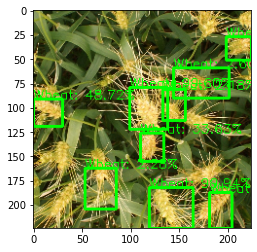

processing image 348a992bb.jpg (6/10 images)
Wheat: 96.36%
Wheat: 89.67%
Wheat: 81.58%
Wheat: 65.51%
Wheat: 32.58%
Wheat: 24.15%
Wheat: 8.80%
Wheat: 1.05%


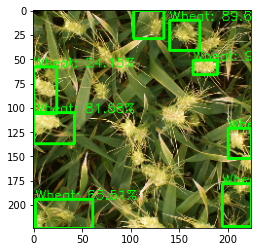

processing image 2fd875eaa.jpg (7/10 images)
Wheat: 95.87%
Wheat: 47.63%
Wheat: 44.72%
Wheat: 34.19%
Wheat: 28.21%
Wheat: 22.07%
Wheat: 18.62%
Wheat: 10.21%
Wheat: 7.78%
Wheat: 5.93%
Wheat: 5.19%
Wheat: 3.74%
Wheat: 2.98%


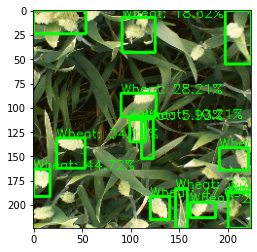

processing image f5a1f0358.jpg (8/10 images)
Wheat: 82.32%
Wheat: 53.78%
Wheat: 23.58%
Wheat: 15.78%
Wheat: 6.42%
Wheat: 1.47%
Wheat: 1.13%


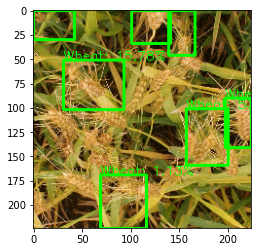

processing image cb8d261a3.jpg (9/10 images)
Wheat: 99.21%
Wheat: 96.81%
Wheat: 57.63%
Wheat: 19.00%
Wheat: 3.33%
Wheat: 1.19%


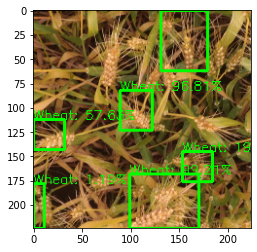

processing image 53f253011.jpg (10/10 images)
Wheat: 99.81%
Wheat: 92.73%
Wheat: 89.52%
Wheat: 84.53%
Wheat: 71.34%
Wheat: 49.34%
Wheat: 40.91%
Wheat: 29.42%
Wheat: 12.78%
Wheat: 5.32%
Wheat: 3.99%
Wheat: 3.30%
Wheat: 2.75%


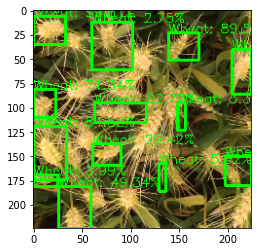

In [18]:
#USE THIS
totalPositive = 0 
totalNegative = 0
count = 0

#get the top 10 confidence boxes
model = load_model("rcnn_denseNet121_v6.h5", custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.01)})
# selective search 

#loop through training images
for i in os.listdir(directory + '/test'): 
    count += 1
    print('processing image {} ({}/{} images)'.format(i, count,len(list(os.listdir(directory + '/test')))))
    img_id = i[:-4]
    
    image = cv2.imread('{}/test/{}'.format(directory, i))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    #run selective search 
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imout = image.copy()
    
    #[(confidence), (result)]
    confidence_list = []
    for counter, result in enumerate(rects):
        if counter < 2000: 
            x,y,w,h = result 
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out = model.predict(img)
            confidence_list.append((x,y,out[0][0], w,h))
#     confidence_list.sort(key=lambda x:x[0])

    #non-maximum suppression 
    nms_list = nms(confidence_list)
    for i in nms_list: 
        x,y, confidence, w, h = i
        if confidence > 0.01: 
            cv2.rectangle(imout, (x,y), (x+w, y+h), (0,255,0), 2)
            text = "Wheat: {:.2f}%".format(confidence*100)
            print(text)
            cv2.putText(imout, text, (x,y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    plt.imshow(imout)
    plt.show() 



processing image 796707dd7.jpg (1/10 images)
17.07%
14.08%
8.64%
6.19%
5.91%
4.76%
2.77%
2.30%
2.29%
2.20%
2.07%


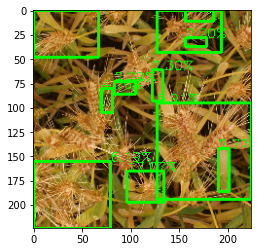

processing image 51f1be19e.jpg (2/10 images)
99.19%
98.83%
97.06%
61.93%
36.84%
12.94%
12.09%
6.65%
5.60%
5.02%
4.85%
4.08%
3.57%
3.52%
3.37%
3.26%
3.18%
3.11%
2.57%
2.44%
2.29%
2.28%
2.21%


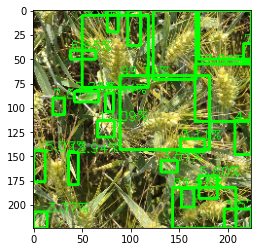

processing image 51b3e36ab.jpg (3/10 images)
99.94%
99.92%
89.80%
82.62%
55.89%
30.34%
29.91%
21.75%
13.45%
10.81%
8.99%
8.48%
6.44%
5.70%
5.15%
3.80%
3.10%
2.81%
2.52%
2.31%
2.11%


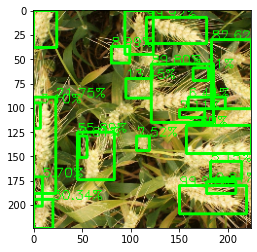

processing image aac893a91.jpg (4/10 images)
96.30%
94.79%
93.09%
74.42%
48.10%
18.97%
14.37%
7.68%
6.48%
6.29%
5.40%
3.80%
3.69%
3.61%
3.57%
3.37%
3.32%
3.01%
2.53%
2.52%
2.44%
2.28%


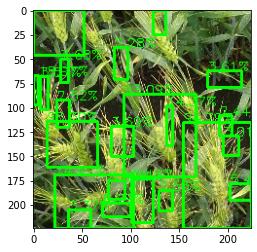

processing image cc3532ff6.jpg (5/10 images)
99.36%
94.72%
71.61%
47.90%
12.42%
8.77%
8.18%
4.84%
4.55%
3.76%
3.29%
2.34%
2.29%
2.12%


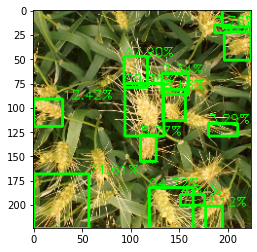

processing image 348a992bb.jpg (6/10 images)
75.43%
46.88%
16.90%
13.01%
9.72%
9.13%
7.90%
6.91%
6.05%
5.21%
4.08%
3.06%
2.48%
2.32%
2.18%


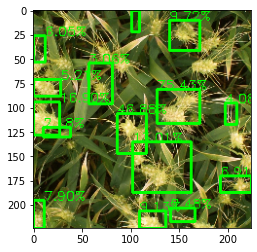

processing image 2fd875eaa.jpg (7/10 images)
83.58%
82.68%
58.19%
16.86%
16.42%
13.42%
12.70%
10.64%
10.44%
8.71%
7.37%
6.96%
6.23%
6.19%
4.14%
3.96%
3.51%
2.90%
2.83%
2.52%
2.40%
2.10%


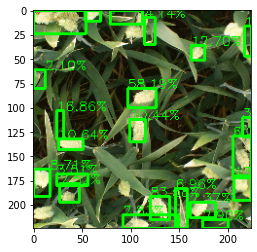

processing image f5a1f0358.jpg (8/10 images)
80.36%
46.36%
34.95%
12.66%
8.28%
3.76%
3.02%
2.68%
2.61%
2.07%


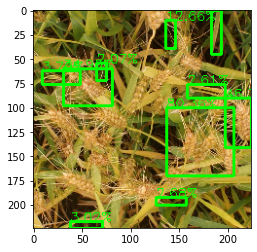

processing image cb8d261a3.jpg (9/10 images)
91.90%
17.40%
9.32%
7.03%
5.60%
4.17%


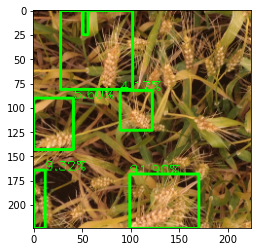

processing image 53f253011.jpg (10/10 images)
99.94%
87.95%
79.16%
74.21%
56.65%
14.37%
13.31%
12.83%
9.07%
7.61%
6.66%
6.57%
5.23%
4.96%
3.04%
2.12%


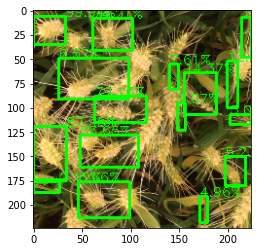

In [7]:
###results of v7
totalPositive = 0 
totalNegative = 0
count = 0

#get the top 10 confidence boxes
model = load_model("rcnn_denseNet121_v7.h5", custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU(alpha=0.01)})
# selective search 

#loop through training images
for i in os.listdir(directory + '/test'): 
    count += 1
    print('processing image {} ({}/{} images)'.format(i, count,len(list(os.listdir(directory + '/test')))))
    img_id = i[:-4]
    
    image = cv2.imread('{}/test/{}'.format(directory, i))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
    #run selective search 
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()
    imout = image.copy()
    
    #[(confidence), (result)]
    confidence_list = []
    for counter, result in enumerate(rects):
        if counter < 2000: 
            x,y,w,h = result 
            timage = imout[y:y+h, x:x+w]
            resized = cv2.resize(timage, (224,224), interpolation=cv2.INTER_AREA)
            img = np.expand_dims(resized, axis=0)
            out = model.predict(img)
            confidence_list.append((x,y,out[0][0], w,h))

    #non-maximum suppression 
    nms_list = nms(confidence_list)
    for i in nms_list: 
        x,y, confidence, w, h = i
        if confidence > 0.02: 
            cv2.rectangle(imout, (x,y), (x+w, y+h), (0,255,0), 2)
            text = "{:.2f}%".format(confidence*100)
            print(text)
            cv2.putText(imout, text, (x if x > 1 else x+w,y), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 255, 0), 1)
    plt.imshow(imout)
    plt.show() 


In [ ]:
# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

In [ ]:
# # serialize the model to disk
# print("[INFO] saving mask detector model...")
# model.save(config.MODEL_PATH, save_format="h5")
# # serialize the label encoder to disk
# print("[INFO] saving label encoder...")
# f = open(config.ENCODER_PATH, "wb")
# f.write(pickle.dumps(lb))
# f.close()

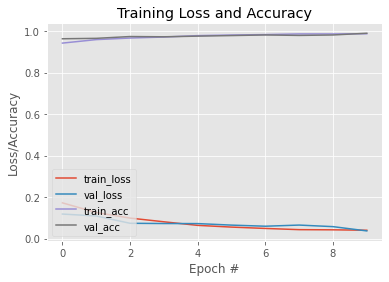

In [5]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
# plt.savefig(args["plot"])